# Titanic

[Tensorflow](#topic-1) | [Pytorch](#topic-2) | [Visualizatons](#topic-3) 


In [1]:
#import data minuplations modules
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline

#import viuslaization models
import matplotlib.pyplot as plt
import seaborn as sns

#import normalization modules
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#import preprocessing train_test_split module
# from sklearn.model_selection import train_test_split # Do not need this with the multiple datasets kaggle has given

#import machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC

#import NN models - Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#import NN models - Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models

#import accuracy_score function from sklearn.metrics to score models better
from sklearn.metrics import accuracy_score

In [2]:
#load the data into dataframes
#data retrieved from kaggle competitions
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")

In [3]:
#Dummies variables for PClass to prevent bias toward one number being weighed more than another
train = pd.concat([train, pd.get_dummies(train["Pclass"], prefix='Pclass')], axis=1)
test = pd.concat([test, pd.get_dummies(test["Pclass"], prefix='Pclass')], axis=1)

# Let's make the sex cloumn into a binary column
train['Sex_binary'] = train.Sex.map({"male": 0, "female": 1}) 
test['Sex_binary'] = test.Sex.map({"male": 0, "female": 1})

# train.head()

In [4]:
# columns_to_drop = ["Pclass", "Name", "Sex", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]
columns_to_drop = ["Pclass", "Name", "Sex",  "Ticket", "Cabin", "Embarked"]

train = train.drop(columns_to_drop, axis = 1)
test = test.drop(columns_to_drop, axis = 1)
# train.head()

In [5]:

#Let's fill in the ages with the mean of all ages.
train['Age'].fillna(value = round(train['Age'].mean()), inplace = True) #look up .fillna function
test['Age'].fillna(value = round(test['Age'].mean()), inplace = True) 
train["Age"].count() #now we have every row accounted for. 

# test["Fare"].dropna(axis=0, how='any', inplace=True)
test['Fare'].fillna(value = round(test['Fare'].mean()), inplace = True) 

C:\Users\Domenick Dobbs\AppData\Local\Temp\ipykernel_20900\1733767599.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(value = round(train['Age'].mean()), inplace = True) #look up .fillna function
C:\Users\Domenick Dobbs\AppData\Local\Temp\ipykernel_20900\1733767599.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate objec

# Prepare the data
 We were given two datasets so we will split them accordingly. WIth one dataset we would use the train_test_split function from the model selection of sklearn. 

In [6]:
#I want to focus on training a model on Age, Sex_binary, FirstClass, SecondClass, ThirdClass, "SibSp", "Parch", "Fare"
#The goal is to predict whether or not the user survived based on this. 
train_features = train[["Age", "Sex_binary", "Pclass_1","Pclass_2", "Pclass_3", "Fare"]]
train_labels = train["Survived"]
test_features = test[["Age", "Sex_binary", "Pclass_1", "Pclass_2", "Pclass_3", "Fare"]]
test_labels = gender_submission["Survived"]

#initialize an accuracy test key = model , value = accuracy score
model_accuracy_titanic_compare = {}

In [ ]:
train.describe()

In [7]:
def train_and_evaluate_model(model, scaler, train_features, train_labels, test_features, test_labels):
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)
    
    model.fit(train_features_scaled, train_labels)
    y_predict = model.predict(test_features_scaled)
    
    accuracy = accuracy_score(test_labels, y_predict)
    
    model_key = f"{model.__class__.__name__} - {scaler.__class__.__name__}"
    model_accuracy_titanic_compare[model_key] = accuracy
    
    return accuracy

In [8]:
# Initialize Scalar Models
scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

In [9]:
# Scale the feature data so it has mean = 0 and standard deviation = 1
# scaler = StandardScaler()
# train_features_Scalar = scaler.fit_transform(train_features)
# test_features_Scalar = scaler.transform(test_features)

# MinMaxScaler = MinMaxScaler()
# train_features_MinMax = scaler.fit_transform(train_features)
# test_features_MinMax = scaler.transform(test_features)

# robust_scale = RobustScaler()
# train_features_Robust = robust_scale.fit_transform(train_features)
# test_features_Robust = robust_scale.transform(test_features)

# Compare all models against 3 scalar functions
Not the Neural networks

In [10]:
#initialze Logistic regression Models models
model = LogisticRegression()
model2 = LogisticRegression()
model3 = LogisticRegression()

# Initialize DecisionTreeClassifier Models
tree_model1 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
tree_model2 = DecisionTreeClassifier(criterion='entropy', max_depth=3)
tree_model3 = DecisionTreeClassifier(criterion='entropy', max_depth=3)

# Initilize the RandomForest Classifiers 
RFC_model1 = RandomForestClassifier(n_estimators=80, criterion='gini', max_depth=4)
RFC_model2 = RandomForestClassifier(n_estimators=80, criterion='gini', max_depth=4)
RFC_model3 = RandomForestClassifier(n_estimators=80, criterion='gini', max_depth=4)

#initialize naive bayes
nb_model1 = GaussianNB()
nb_model2 = GaussianNB()
nb_model3 = GaussianNB()

# Initialize KNN
knn_model1 = KNeighborsClassifier(n_neighbors=3) 
knn_model2 = KNeighborsClassifier(n_neighbors=3) 
knn_model3 = KNeighborsClassifier(n_neighbors=3) 

# Initilize Support Vector Machines
svm_svc_model1 = svm.SVC(kernel='poly', C=1.5) 
svm_svc_model2 = svm.SVC(kernel='poly', C=1.5) 
svm_svc_model3 = svm.SVC(kernel='poly', C=1.5) 

# Train and evaluate models
LR_model_acc_score_Scalar = train_and_evaluate_model(model, scaler, train_features, train_labels, test_features, test_labels)
LR_model_acc_score_MinMax = train_and_evaluate_model(model2, min_max_scaler, train_features, train_labels, test_features, test_labels)
LR_model_acc_score_Robust = train_and_evaluate_model(model3, robust_scaler, train_features, train_labels, test_features, test_labels)

DecisionTree_acc_score_Scalar = train_and_evaluate_model(tree_model1, scaler, train_features, train_labels, test_features, test_labels)
DecisionTree_acc_score_MinMax = train_and_evaluate_model(tree_model2, min_max_scaler, train_features, train_labels, test_features, test_labels)
DecisionTree_acc_score_Robust = train_and_evaluate_model(tree_model3, robust_scaler, train_features, train_labels, test_features, test_labels)

RandomForest_acc_score_Scalar = train_and_evaluate_model(RFC_model1, scaler, train_features, train_labels, test_features, test_labels)
RandomForest_acc_score_MinMax = train_and_evaluate_model(RFC_model2, min_max_scaler, train_features, train_labels, test_features, test_labels)
RandomForest_acc_score_Robust = train_and_evaluate_model(RFC_model3, robust_scaler, train_features, train_labels, test_features, test_labels)

NB_acc_score_Scalar = train_and_evaluate_model(nb_model1, scaler, train_features, train_labels, test_features, test_labels)
NB_acc_score_MinMax = train_and_evaluate_model(nb_model2, min_max_scaler, train_features, train_labels, test_features, test_labels)
NB_acc_score_Robust = train_and_evaluate_model(nb_model3, robust_scaler, train_features, train_labels, test_features, test_labels)

KNN_acc_score_Scalar = train_and_evaluate_model(knn_model1, scaler, train_features, train_labels, test_features, test_labels)
KNN_acc_score_MinMax = train_and_evaluate_model(knn_model2, min_max_scaler, train_features, train_labels, test_features, test_labels)
KNN_acc_score_Robust = train_and_evaluate_model(knn_model3, robust_scaler, train_features, train_labels, test_features, test_labels)

SVC_acc_score_Scalar = train_and_evaluate_model(svm_svc_model1, scaler, train_features, train_labels, test_features, test_labels)
SVC_acc_score_MinMax = train_and_evaluate_model(svm_svc_model2, min_max_scaler, train_features, train_labels, test_features, test_labels)
SVC_acc_score_Robust = train_and_evaluate_model(svm_svc_model3, robust_scaler, train_features, train_labels, test_features, test_labels)



# print it all
model_accuracy_titanic_compare

{'LogisticRegression - StandardScaler': 0.9641148325358851,
 'LogisticRegression - MinMaxScaler': 0.9784688995215312,
 'LogisticRegression - RobustScaler': 0.9617224880382775,
 'DecisionTreeClassifier - StandardScaler': 0.9617224880382775,
 'DecisionTreeClassifier - MinMaxScaler': 0.9617224880382775,
 'DecisionTreeClassifier - RobustScaler': 0.9617224880382775,
 'RandomForestClassifier - StandardScaler': 0.930622009569378,
 'RandomForestClassifier - MinMaxScaler': 0.8229665071770335,
 'RandomForestClassifier - RobustScaler': 0.9090909090909091,
 'GaussianNB - StandardScaler': 0.7655502392344498,
 'GaussianNB - MinMaxScaler': 0.7655502392344498,
 'GaussianNB - RobustScaler': 0.7655502392344498,
 'KNeighborsClassifier - StandardScaler': 0.8373205741626795,
 'KNeighborsClassifier - MinMaxScaler': 0.8373205741626795,
 'KNeighborsClassifier - RobustScaler': 0.8133971291866029,
 'SVC - StandardScaler': 0.9665071770334929,
 'SVC - MinMaxScaler': 0.9449760765550239,
 'SVC - RobustScaler': 0.83

In [11]:
#For the contest ;)
max_key_value_pair = max(model_accuracy_titanic_compare.items(), key=lambda x: x[1])
print(max_key_value_pair)

('LogisticRegression - MinMaxScaler', 0.9784688995215312)


In [12]:
# model = LogisticRegression()
# model2 = LogisticRegression()
# model3 = LogisticRegression()

# model.fit(train_features_Scalar, train_labels)
# model2.fit(train_features_MinMax, train_labels)
# model3.fit(train_features_Robust, train_labels)

# # print(model.score(train_features, train_labels)) #I Switched to the metric module for accuracy_score
# y_predict_Scalar = model.predict(test_features_Scalar)
# y_predict_MinMax = model.predict(test_features_MinMax)
# y_predict_Robust = model.predict(test_features_Robust)

# LR_model_acc_score_Scalar = accuracy_score(test_labels, y_predict_Scalar)
# LR_model_acc_score_MinMax = accuracy_score(test_labels, y_predict_MinMax)
# LR_model_acc_score_Robust = accuracy_score(test_labels, y_predict_Robust)

# model_accuracy_titanic_compare["Logistic Rregression model Scalar:"] = LR_model_acc_score_Scalar
# model_accuracy_titanic_compare["Logistic Rregression model MinMax:"] = LR_model_acc_score_MinMax
# model_accuracy_titanic_compare["Logistic Rregression model Robust:"] = LR_model_acc_score_Robust
# print(f"Accuracy Scalar: {LR_model_acc_score_Scalar}")
# print(f"Accuracy MinMax: {LR_model_acc_score_MinMax}")
# print(f"Accuracy Robust: {LR_model_acc_score_Robust}")

In [13]:
#I remember when I did this 2 years ago, we used Jack and Rose then ourselves to make predictions on the model and we mad ethem in a np.array
Jack = np.array([20.0, 0.0, 0.0, 0.0, 1.0, 8.0500])
Rose = np.array([17.0, 1.0, 1.0, 0.0, 0.0, 71.2833])
Dom = np.array([29.0,  0.0, 0.0, 1.0, 0.0, 30.0708])

passenger_predict = np.array([Jack, Rose, Dom])

passenger_predict = scaler.transform(passenger_predict)

#prediction time! My favorite part
# Make survival predictions!
print(model.predict(passenger_predict)) #This will print a 1 or 0 for surivied or did not survive 
print(model.predict_proba(passenger_predict)) #this will give us how likely for each option

[0 1 0]
[[0.8858476  0.1141524 ]
 [0.05065699 0.94934301]
 [0.75687994 0.24312006]]


c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


- Jack had an 88.5% of NOT surviving based on the data. 
- Rose had a 95% chance of surviving. 
- Dom would of had a 75.9% chance of NOT surviving.

# Start Decision Tree model


In [14]:
# tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=3)
# #does not need normalized data
# tree_model.fit(train_features_Scalar, train_labels)
# y_predict = tree_model.predict(test_features_Scalar)

# tree_model_acc_score = accuracy_score(test_labels, y_predict)
# model_accuracy_titanic_compare["Decision Tree model:"] = tree_model_acc_score
# print(f"Accuracy: {tree_model_acc_score}")

In [15]:
# passenger_predict
print(tree_model1.predict(passenger_predict))
print(tree_model1.predict_proba(passenger_predict))

[0 1 0]
[[0.8975     0.1025    ]
 [0.02       0.98      ]
 [0.67721519 0.32278481]]


# Start Random Forest Classifier

In [16]:
# RFC_model = RandomForestClassifier(n_estimators=90, criterion='gini', max_depth=5)

# RFC_model.fit(train_features_Scalar, train_labels)

# y_predict_RFC = RFC_model.predict(test_features_Scalar)

# #Now it should of predicted if it thinks the people in the test_features dataset survived. Lets compare that to our information of their actual survival rates

# rfl_acc = accuracy_score(test_labels, y_predict_RFC)

# model_accuracy_titanic_compare["Random Forrect Classifier model:"] = rfl_acc

# print("Accuracy:", accuracy_score(test_labels, y_predict_RFC))

In [17]:
# passenger_predict
print(RFC_model1.predict(passenger_predict))
print(RFC_model1.predict_proba(passenger_predict))

[0 1 0]
[[0.8644932  0.1355068 ]
 [0.06547823 0.93452177]
 [0.76303864 0.23696136]]


# Naive Bayes for Classification


In [18]:
# #We should not need to do much for this one
# nb_model = GaussianNB()

# nb_model.fit(train_features_Scalar, train_labels)

# y_predict_NB = nb_model.predict(test_features_Scalar)

# NB_acc_score = accuracy_score(test_labels, y_predict_NB)
# model_accuracy_titanic_compare["Naive Bayes Classifier model:"] = NB_acc_score
# print(f"Accuracy: {NB_acc_score}")

In [19]:
# passenger_predict
print(nb_model1.predict(passenger_predict))
print(nb_model1.predict_proba(passenger_predict))

[0 1 0]
[[0.98184197 0.01815803]
 [0.00758405 0.99241595]
 [0.8395652  0.1604348 ]]


# KNN

In [20]:
# knn_model = KNeighborsClassifier(n_neighbors=2) 

# knn_model.fit(train_features_Scalar, train_labels)

# y_predict = knn_model.predict(test_features_Scalar)

# knn_acc = accuracy_score(test_labels, y_predict)
# model_accuracy_titanic_compare["K Nearest Neighbor model:"] = knn_acc
# knn_acc

In [21]:
print(knn_model1.predict(passenger_predict))
print(knn_model1.predict_proba(passenger_predict))

[0 1 0]
[[0.66666667 0.33333333]
 [0.         1.        ]
 [1.         0.        ]]


# Support Vector Machine - Classifer

In [22]:
# svm_svc_model = svm.SVC(kernel='poly', C=1.5) 

# svm_svc_model.fit(train_features_Scalar, train_labels)

# y_predict_svm = svm_svc_model.predict(test_features_Scalar)

# svm_acc = accuracy_score(test_labels, y_predict_svm)
# model_accuracy_titanic_compare["Support Vector Classifier model:"] = svm_acc
# svm_acc

In [23]:
print(svm_svc_model1.predict(passenger_predict))


[0 1 0]


# Nueral Networks - Pytorch

<a id="topic-2">Pytorch</a>

[Back to Top](#top)

In [24]:
#What version am I on?
torch.__version__

'2.2.1+cpu'

In [25]:
type(train_labels)

pandas.core.series.Series

In [26]:
train_features_pre_normalized = train[["Age", "Sex_binary", "Pclass_1", "Pclass_2", "Pclass_3", "Fare"]]
train_labels_pre_normalized = train["Survived"]
test_features_pre_normalized = test[["Age", "Sex_binary", "Pclass_1", "Pclass_2", "Pclass_3", "Fare"]]
test_labels_pre_normalized = gender_submission["Survived"]
train_features_pre_normalized.describe()

,Age,Sex_binary,Fare
count,891.000000,891.000000,891.000000
mean,29.758889,0.352413,32.204208
std,13.002570,0.477990,49.693429
min,0.420000,0.000000,0.000000
25%,22.000000,0.000000,7.910400
50%,30.000000,0.000000,14.454200
75%,35.000000,1.000000,31.000000
max,80.000000,1.000000,512.329200


In [27]:
# Remove non-numeric columns
numeric_columns = train_features_pre_normalized.select_dtypes(include=[np.number]).columns
train_features_pre_normalized = train_features_pre_normalized[numeric_columns]
test_features_pre_normalized = test_features_pre_normalized[numeric_columns]

# Remove rows containing NaN values
train_features_pre_normalized = train_features_pre_normalized.dropna()
test_features_pre_normalized = test_features_pre_normalized.dropna()

# Convert data to PyTorch tensors
train_features_pt = torch.tensor(train_features_pre_normalized.values).float()
# train_labels = torch.tensor(train_labels_pre_normalized.values).float()
test_features_pt = torch.tensor(test_features_pre_normalized.values).float()
# test_labels = torch.tensor(test_labels_pre_normalized.values).float()


# Convert labels to NumPy arrays
train_labels_np = train_labels.values
test_labels_np = test_labels.values

# Convert to PyTorch tensors with explicit dtype
train_labels_pt = torch.tensor(train_labels_np, dtype=torch.long)
test_labels_pt = torch.tensor(test_labels_np, dtype=torch.long)


# Create TensorDatasets
train_dataset = TensorDataset(train_features_pt, train_labels_pt)
test_dataset = TensorDataset(test_features_pt, test_labels_pt)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [28]:
class TitanicNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TitanicNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define network dimensions
input_size = train_features_pt.shape[1]
hidden_size = 10  # You can adjust this
output_size = 2  # Two classes: Survived or Not Survived

# Create the network
PyTorchmodel = TitanicNN(input_size, hidden_size, output_size)


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(PyTorchmodel.parameters(), lr=0.001)


In [30]:
num_epochs = 100  # adjust this
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = PyTorchmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')


Epoch 1/100, Loss: 5.163398930004665
Epoch 2/100, Loss: 2.9305990764072964
Epoch 3/100, Loss: 1.4336673191615514
Epoch 4/100, Loss: 0.984242149761745
Epoch 5/100, Loss: 0.8876494424683707
Epoch 6/100, Loss: 0.7774885892868042
Epoch 7/100, Loss: 0.7012170170034681
Epoch 8/100, Loss: 0.6547842877251762
Epoch 9/100, Loss: 0.6420247895377023
Epoch 10/100, Loss: 0.6411179346697671
Epoch 11/100, Loss: 0.6363337465694973
Epoch 12/100, Loss: 0.6327004688126701
Epoch 13/100, Loss: 0.6291823216847011
Epoch 14/100, Loss: 0.6262416115828923
Epoch 15/100, Loss: 0.6265156354222979
Epoch 16/100, Loss: 0.6193090294088636
Epoch 17/100, Loss: 0.6183282136917114
Epoch 18/100, Loss: 0.6129361391067505
Epoch 19/100, Loss: 0.611432250056948
Epoch 20/100, Loss: 0.6094919975314822
Epoch 21/100, Loss: 0.6064639559813908
Epoch 22/100, Loss: 0.6069518498011998
Epoch 23/100, Loss: 0.6026630614485059
Epoch 24/100, Loss: 0.6018158538000924
Epoch 25/100, Loss: 0.5987740478345326
Epoch 26/100, Loss: 0.591936873538153

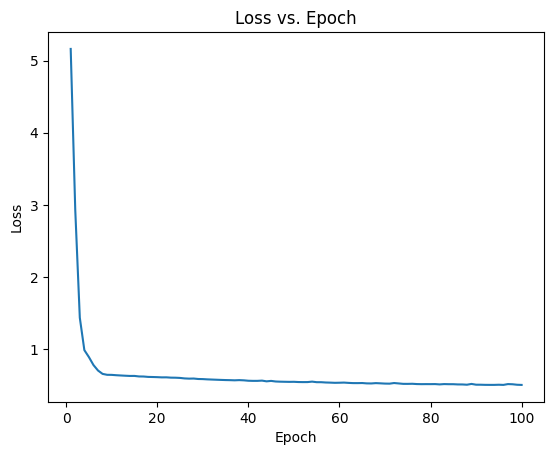

In [31]:
plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.show()


In [32]:
PyTorchmodel.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = PyTorchmodel(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
model_accuracy_titanic_compare["Pytorch Neural Network model:"] = accuracy
print(f'Accuracy on test set: {accuracy * 100}%')


Accuracy on test set: 93.77990430622009%


In [33]:
# #Predict time!!

# passenger_predict_tensor = torch.tensor(passenger_predict).float()

# with torch.no_grad():
#     outputs = PyTorchmodel(passenger_predict_tensor)
#     probabilities = torch.softmax(outputs, dim=1)
#     predictions = torch.argmax(probabilities, dim=1)

In [34]:
# # Set the PyTorchmodel to evaluation mode
# PyTorchmodel.eval()

# # Make predictions
# with torch.no_grad():
#     outputs = PyTorchmodel(passenger_predict_tensor)
#     probabilities = torch.softmax(outputs, dim=1)
#     predictions = torch.argmax(probabilities, dim=1)

# # Convert predictions and probabilities to numpy arrays for easy printing
# predictions_np = predictions.tolist()
# probabilities_np = probabilities.tolist()

# # Print results
# print(predictions_np)
# probabilities_np


<a id="topic-1">Tensorflow</a> 

[Back to Top](#top)


In [35]:
# Convert data to TensorFlow tensors
train_features_tf = tf.convert_to_tensor(train_features.values, dtype=tf.float32)
train_labels_tf = tf.convert_to_tensor(train_labels.values, dtype=tf.int64)
test_features_tf = tf.convert_to_tensor(test_features.values, dtype=tf.float32)
test_labels_tf = tf.convert_to_tensor(test_labels.values, dtype=tf.int64)

# Define network dimensions
input_size = train_features_pt.shape[1]
hidden_size = 12  # You can adjust this
output_size = 2  # Two classes: Survived or Not Survived


In [36]:
# make the nn
model_tf = models.Sequential([
    layers.Dense(hidden_size, activation='relu', input_shape=(input_size,)),
    layers.Dense(output_size, activation='softmax')
])

# model_tf = models.Sequential([
#     layers.Dense(hidden_size, activation='relu', input_shape=(input_size,), kernel_regularizer='l2'),
#     layers.Dropout(0.3), 
#     layers.Dense(16, activation='relu', kernel_regularizer='l2'), 
#     layers.Dense(output_size, activation='softmax')
# ])


c:\Users\Domenick Dobbs\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# compile the model here
# model_tf.compile(optimizer='adam',
#                 loss='sparse_categorical_crossentropy',
#                 metrics=['accuracy'])

# model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Assuming labels are not one-hot encoded
#                 metrics=['accuracy'])


In [38]:
#model train
# history = model_tf.fit(train_features_tf, train_labels_tf, epochs=200, batch_size=batch_size, verbose=1)


In [39]:
# loss, accuracy = model_tf.evaluate(test_features_tf, test_labels_tf)
# model_accuracy_titanic_compare["Tensorflow Neural Network model:"] = accuracy
# print(f'Accuracy on test set: {accuracy}')


In [40]:
# passenger_predict_tf = tf.convert_to_tensor(passenger_predict, dtype=tf.float32)
# predictions_tf = model_tf.predict(passenger_predict_tf)
# predicted_classes_tf = tf.argmax(predictions_tf, axis=1).numpy()

# print(predicted_classes_tf)
# print(predictions_tf)


In [41]:
# model_accuracy_titanic_compare

<a id="topic-3">Visualizatons</a>

[Back to Top](#top)

In [42]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [43]:
scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
robust_scaler = RobustScaler()
X_train_std_scalar = scaler.fit_transform(train_features)
X_train_std_minMax = min_max_scaler.fit_transform(train_features)
X_train_std_Robust = robust_scaler.fit_transform(train_features)


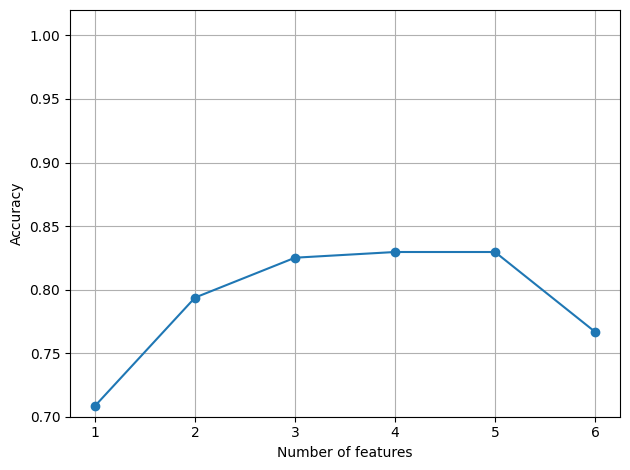

In [44]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std_scalar, train_labels)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('figures/04_09.png', dpi=300)
plt.show()

In [45]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = train.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train_std_scalar, train_labels)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]


 1) Pclass_1                       0.330163
 2) Survived                       0.291662
 3) Age                            0.274539
 4) Fare                           0.058431
 5) SibSp                          0.029921
 6) Parch                          0.015283


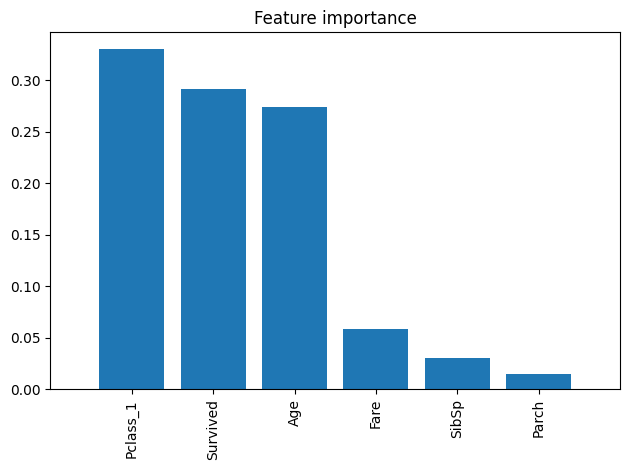

In [46]:
for f in range(X_train_std_scalar.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature importance')
plt.bar(range(X_train_std_scalar.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train_std_scalar.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train_std_scalar.shape[1]])
plt.tight_layout()
# plt.savefig('figures/04_10.png', dpi=300)
plt.show()